In [ ]:
!pip install geotile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 21.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from geotile import GeoTile

In [ ]:
PATH_TRAIN_X = r'/content/drive/MyDrive/Pune_data/train_x.tif'
PATH_TRAIN_Y = r'/content/drive/MyDrive/Pune_data/Train x vector'
PATH_TEST_X = r'/content/drive/MyDrive/nayagarh_data/train_x.tif'
PATH_TEST_Y = r'/content/drive/MyDrive/nayagarh_data/Train x vector'

In [ ]:
gt_train = GeoTile(PATH_TRAIN_X)
gt_train.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 2237,
 'height': 1861,
 'count': 4,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 85.17259585392307,
        0.0, -8.983152841195215e-05, 20.376126263569457)}

In [ ]:
gt_train.generate_tiles(r'/content/drive/MyDrive/Pune_data/train_x_tiles', prefix='train_')

In [ ]:
gt_train.rasterization(PATH_TRAIN_Y, '/content/drive/MyDrive/Pune_data/y_train.tif')

In [ ]:
gt_train_y = GeoTile('/content/drive/MyDrive/Pune_data/y_train.tif')
gt_train_y.generate_tiles(r'/content/drive/MyDrive/Pune_data/train_y_tiles', prefix='train_')

In [ ]:
gt_test = GeoTile(PATH_TEST_X)

gt_test.generate_tiles('/content/drive/MyDrive/Pune_data/test_x_tiles', prefix = 'test_')

gt_test.rasterization(PATH_TEST_Y, '/content/drive/MyDrive/Pune_data/y_test.tif')

gt_test_y = GeoTile('/content/drive/MyDrive/Pune_data/y_test.tif')
gt_test_y.generate_tiles(r'/content/drive/MyDrive/Pune_data/test_y_tiles', prefix = 'test_')

/usr/local/lib/python3.10/dist-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape None at index 45 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)


In [ ]:
# generate tiles and store it inside geotile package
gt_train.generate_tiles(save_tiles=False)
gt_train_y.generate_tiles(save_tiles=False)

# preprocessing (eg. convert nan to zero and normalization of tiles)
gt_train.convert_nan_to_zero()
# gt_train.normalize_tiles()



In [ ]:
gt_train.normalize_tiles()

/usr/local/lib/python3.10/dist-packages/geotile/GeoTile.py:602: RuntimeWarning: invalid value encountered in divide
  self.tile_data[:, :, :, channel] = (


In [ ]:
import numpy as np
gt_train.tile_data.min(), gt_train.tile_data.max()

(nan, nan)

In [ ]:
# save it as a numpy array
gt_train.save_numpy('/content/drive/MyDrive/nayagarh_data/train_x.npy')
gt_train_y.save_numpy('/content/drive/MyDrive/y_train.npy')

In [ ]:
gt_test.generate_tiles(save_tiles=False)
gt_test_y.generate_tiles(save_tiles=False)

# preprocessing (eg. convert nan to zero and normalization of tiles)
gt_test.convert_nan_to_zero()
gt_test.normalize_tiles()

# save it as a numpy array
gt_test.save_numpy('/content/drive/MyDrive/nayagarh_data/test_x.npy')
gt_test_y.save_numpy('/content/drive/MyDrive/nayagarh_data/y_test.npy')

In [ ]:
X_train = np.load('/content/drive/MyDrive/nayagarh_data/train_x.npy')
X_train.max(), X_train.min(), X_train.dtype, X_train.shape

(1.0, 0.0, dtype('float32'), (54, 256, 256, 4))

In [ ]:
y_train= np.load('/content/drive/MyDrive/y_train.npy')

33


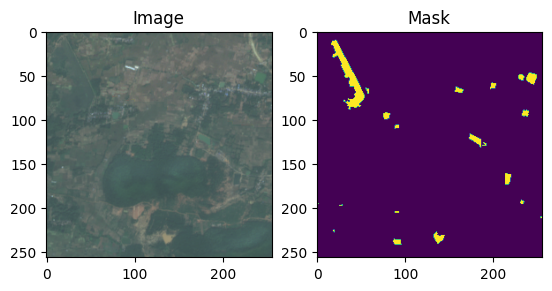

In [ ]:
import matplotlib.pyplot as plt

# Let's plot a sample input RGB image and output image with buildings
fig, (ax1, ax2) = plt.subplots(1,2)
img = np.random.randint(0, X_train.shape[0])
print(img)
ax1.imshow(X_train[img, :, :, :3])
ax2.imshow(y_train[img, :, :, 0])
ax1.set_title("Image")
ax2.set_title('Mask')
plt.show()

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [ ]:
import os
os.chdir(r'/content/drive/MyDrive/nayagarh_data')

In [ ]:
train_xx_initial = np.load('train_x.npy')
train_yy_initial = np.load('y_train.npy')
# test_xx = np.load('test_x.npy')
# test_yy = np.load("y_test.npy")

print(train_xx_initial.shape, train_yy_initial.shape)
train_xx_initial.max(), train_xx_initial.min()

(54, 256, 256, 4) (54, 256, 256, 1)


(1.0, 0.0)

In [ ]:
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import numpy as np

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Flipud(0.5),  # Vertical flip
    iaa.Affine(rotate=(-45, 45)),  # Random rotation between -45 and 45 degrees
    iaa.Affine(scale=(0.5, 1.5)),  # Random scaling between 0.5x and 1.5x
    iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),  # Random translation
    # iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Gaussian noise
    # iaa.ElasticTransformation(alpha=50, sigma=5)  # Elastic deformation
])

In [ ]:
augmented_images = []
augmented_masks = []

num_augmentations = 3
# Apply augmentation to each original image and mask
for i in range(train_xx_initial.shape[0]):
    image = train_xx_initial[i]
    mask = train_yy_initial[i]

    # Create a segmentation map object from the mask
    segmentation_map = SegmentationMapsOnImage(mask, shape=image.shape)

    # Apply augmentation num_augmentations times
    for _ in range(num_augmentations):
        # Apply the same augmentation to both image and mask
        augmented_image, augmented_segmentation_mask = seq.augment(image=image, segmentation_maps=segmentation_map)

        # Append the augmented image and mask to the lists
        augmented_images.append(augmented_image)
        augmented_masks.append(augmented_segmentation_mask.get_arr())

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# append augmented images/masks with original images/masks
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)



In [ ]:
# append augmented images/masks with original images/masks
train_xx = np.concatenate((train_xx_initial, augmented_images), axis=0)
train_yy = np.concatenate((train_yy_initial, augmented_masks), axis=0)

In [ ]:
# release memory
del augmented_images
del augmented_masks

In [ ]:
train_xx.max(), train_xx.min(), train_xx.dtype

(1.0, 0.0, dtype('float32'))

In [ ]:
train_xx.shape, train_yy.shape

((216, 256, 256, 4), (216, 256, 256, 1))

In [ ]:
train_yy.max()

1

In [ ]:
num_samples = train_xx.shape[0]
shuffled_indices = np.random.permutation(num_samples)

train_xx = train_xx[shuffled_indices]
train_yy = train_yy[shuffled_indices]

144


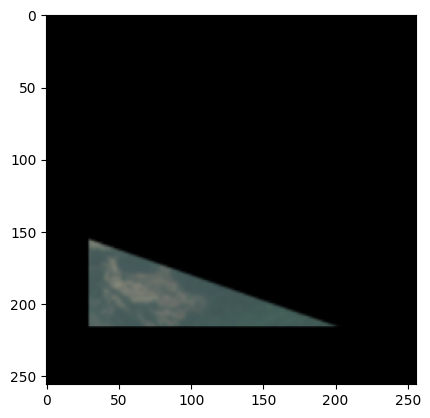

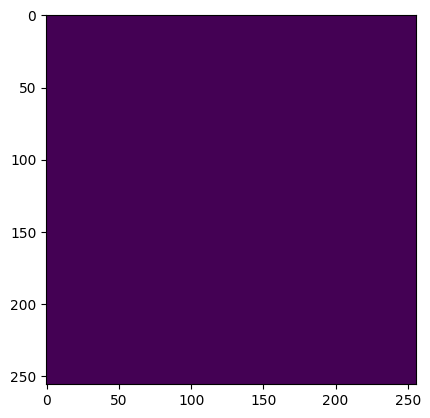

In [ ]:
# Let's plot a sample input RGB image and output image with buildings
img = np.random.randint(0, train_xx.shape[0])
print(img)
plt.imshow(train_xx[img, :, :, :3])
plt.show()
plt.imshow(train_yy[img, :, :, 0])
plt.show()

In [ ]:
x_in = Input(shape=(256, 256, 4))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x_temp)
# use sigmoid activation here because output values are either 0 or 1

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='binary_crossentropy', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
# training model
import tensorflow as tf

# callback function to stop overfitting the model
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_weight.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

callbacks = [
    earlyStopping,
    checkpointer
    ]
history = model.fit(train_xx, train_yy,
                    validation_data=(train_xx, train_yy),
                    epochs=20,
                    batch_size=8,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
27/27 [==============================] - 388s 14s/step - loss: 0.2865 - val_loss: 0.0648

Epoch 1: val_loss improved from inf to 0.06481, saving model to best_weight.h5
Epoch 2/20
27/27 [==============================] - 345s 13s/step - loss: 0.0368 - val_loss: 0.0350

Epoch 2: val_loss improved from 0.06481 to 0.03497, saving model to best_weight.h5
Epoch 3/20
27/27 [==============================] - 354s 13s/step - loss: 0.0265 - val_loss: 0.0293

Epoch 3: val_loss improved from 0.03497 to 0.02928, saving model to best_weight.h5
Epoch 4/20
27/27 [==============================] - 356s 13s/step - loss: 0.0212 - val_loss: 0.0189

Epoch 4: val_loss improved from 0.02928 to 0.01889, saving model to best_weight.h5
Epoch 5/20
27/27 [==============================] - 347s 13s/step - loss: 0.0174 - val_loss: 0.0153

Epoch 5: val_loss improved from 0.01889 to 0.01532, saving model to best_weight.h5
Epoch 6/20
27/27 [==============================] - 360s 13s/step - loss: 0.0151 - v

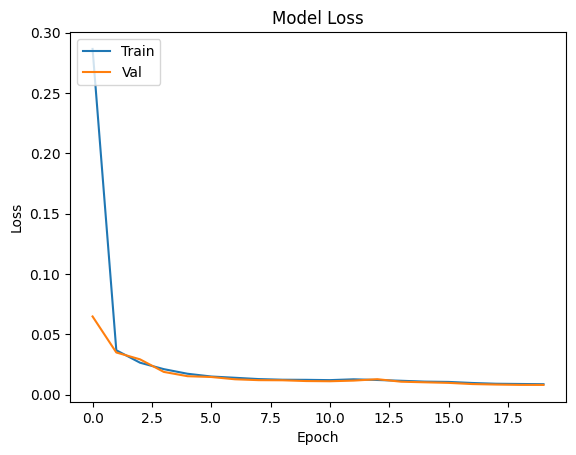

In [ ]:
# plot model loss over training and validation data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_weight.h5')

7/7 [==============================] - 76s 11s/step
(216, 256, 256, 1)


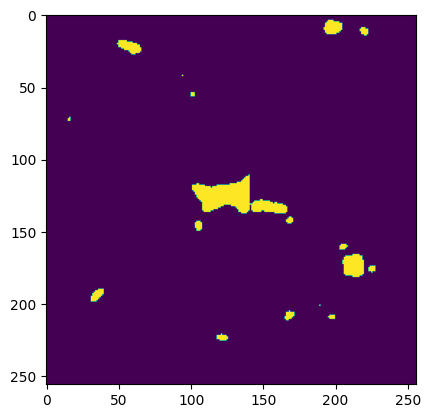

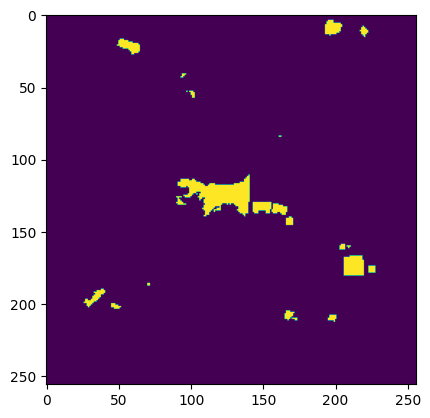

In [ ]:
threshold = 0.3

# prediction of the output
pred_test = model.predict(train_xx)
pred_test = (pred_test > threshold).astype(np.uint8)
print(pred_test.shape)

#let's compare random predicted and actual y values
img = np.random.randint(0, 1)
plt.imshow(pred_test[img, :, :, 0])
plt.show()
plt.imshow(train_yy[img,:,:,0])
plt.show()

In [ ]:
print(img)

In [ ]:
# test_yy = test_yy.astype('uint8')
pred_test = pred_test.astype('uint8')

In [ ]:
def calculate_metrics(ground_truth, predicted_mask):
    # Flatten the binary masks to 1D arrays
    ground_truth = ground_truth.ravel()
    predicted_mask = predicted_mask.ravel()

    # True Positives, False Positives, False Negatives
    TP = np.sum((ground_truth == 1) & (predicted_mask == 1))
    FP = np.sum((ground_truth == 0) & (predicted_mask == 1))
    FN = np.sum((ground_truth == 1) & (predicted_mask == 0))

    # True Negatives (optional, may not be needed for all cases)
    TN = np.sum((ground_truth == 0) & (predicted_mask == 0))

    # Calculate Precision, Recall, and F1 Score
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy =(TP + TN) / (TP + TN + FN + FP)

    # Calculate Intersection over Union (IoU)
    iou = TP / (TP + FP + FN)

    return TP, FP, FN, TN, precision, recall, f1_score, accuracy, iou

In [ ]:
print(calculate_metrics(train_yy, pred_test))

(67889, 21388, 18432, 14048067, 0.7604310180673634, 0.7864714264199905, 0.7732320413672137, 0.9971870139793113, 0.6303001606179613)


For threshold = 0.2
(70823, 29004, 15498, 14040451, 0.7094573612349364, 0.8204608380347772, 0.7609321615058987, 0.9968562655978732, 0.6141166269239107)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
# Reshape the input data to have a single channel
train_xx_flattened = train_xx.reshape(-1, 256 * 256 * 4)
# Reshape the output data to have a single channel
train_yy_flattened = train_yy.reshape(-1, 256 * 256)

Random Forest

In [ ]:
# Define and train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_xx_flattened, train_yy_flattened)

In [ ]:
# Make predictions with Random Forest classifier
rf_predictions = rf_classifier.predict(train_xx_flattened)

In [ ]:
# Calculate F1 score, TP, TN, FP, FN for Random Forest classifier
rf_f1_score = f1_score(train_yy, rf_predictions, average='binary')
rf_conf_matrix = confusion_matrix(train_yy_flattened, rf_predictions)
rf_tp = rf_conf_matrix[1, 1]
rf_tn = rf_conf_matrix[0, 0]
rf_fp = rf_conf_matrix[0, 1]
rf_fn = rf_conf_matrix[1, 0]

# Calculate accuracy for Random Forest classifier
rf_accuracy = accuracy_score(train_yy_flattened, rf_predictions)

In [ ]:
print("Random Forest Classifier:")
print("Accuracy:", rf_accuracy)
print("F1 Score:", rf_f1_score)
print("True Positives:", rf_tp)
print("True Negatives:", rf_tn)
print("False Positives:", rf_fp)
print("False Negatives:", rf_fn)

Suport Vector Machine

In [ ]:
# Define and train SVM with radial basis function kernel
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_xx_flattened, train_yy_flattened)

In [ ]:
# Make predictions with SVM
svm_predictions = svm_classifier.predict(train_xx_flattened)


In [ ]:
# Calculate F1 score, TP, TN, FP, FN for SVM
svm_f1_score = f1_score(train_yy, svm_predictions, average='binary')
svm_conf_matrix = confusion_matrix(train_yy_flattened, svm_predictions)
svm_tp = svm_conf_matrix[1, 1]
svm_tn = svm_conf_matrix[0, 0]
svm_fp = svm_conf_matrix[0, 1]
svm_fn = svm_conf_matrix[1, 0]

# Calculate accuracy for SVM
svm_accuracy = accuracy_score(train_yy_flattened, svm_predictions)

In [ ]:
print("\nSVM with Radial Basis Function Kernel:")
print("Accuracy:", svm_accuracy)
print("F1 Score:", svm_f1_score)
print("True Positives:", svm_tp)
print("True Negatives:", svm_tn)
print("False Positives:", svm_fp)
print("False Negatives:", svm_fn)